# Post processing

This notebook contains all code used to convert the Porosity model realization into the corresponding Permeability distribution based on the available data. A linear conversion is applied based on 12 data points.  

Note: Code for higher order polynomial fit is also included. This can be used in the event that more data is made available in the future that can be used to constrain a higher order relationship.

In [1]:
#module imports
import os
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from PIL import Image
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import scipy.spatial.distance as dist
import scipy
from scipy.optimize import curve_fit
import copy
import pyvista as pv
import pyvistaqt as pvqt
import PVGeo
import datetime

## Data import

The table consists of porosity and permeability values from lab work by Lofi et al. (2013)  
Online address: https://doi.org/10.1130/GES00855.1


In [2]:
por_perm_tab = pd.read_csv("Data/lab_por_perm_lofi.csv")
por_perm_tab['log_perm']=np.log10(por_perm_tab['Permeability [mD]'])
por_perm_tab


,Sample,Well,Sample Label,Depth [m],Lithology,Laboratory Porosity [%],Permeability [mD],log_perm
0,P1,M27,171-R1,489.77,sandstones,46.3,75.0000,1.875061
1,P2,M27,174-R1,494.51,sandstones,40.1,43.0000,1.633468
2,P3,M27,174-R1,494.51,sandstones,45.7,6.0000,0.778151
3,P4,M28,12-R1,254.01,silty claystone,53.0,0.1000,-1.000000
4,P5,M28,40-R1,327.55,sandstone,31.8,2.5000,0.397940
5,P6,M28,123-R1,540.04,sandstone,24.0,0.0080,-2.096910
6,P7,M29,72-R1,343.58,siltstone,3.0,0.0006,-3.221849
7,P8,M29,119-R1,479.52,siltstone,0.4,0.0001,-4.000000
8,P9,M29,164-R2,611.87,sandstone,14.0,0.0040,-2.397940
9,P10,M29,173-R1,636.23,sandstone,29.1,0.4000,-0.397940


## Permeability conversion

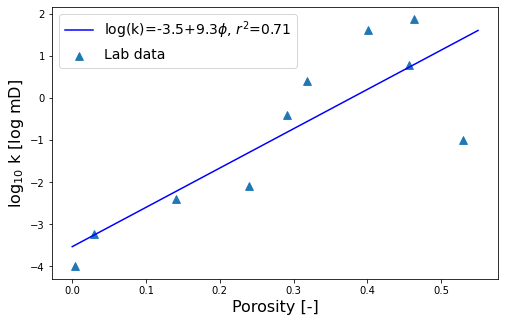

In [3]:
xdat=por_perm_tab['Laboratory Porosity [%]']/100
ydat=por_perm_tab['log_perm']
#log perm vs por
def poly3_trend(x, a, b, c):   # second order polynomial trend
    return a + b * x + c * x ** 2 

def lin_trend(x, a, b):   #linear trend
    return a+b*x



# Trend fitting polynomial
pars_p3, cov_p3 = curve_fit(poly3_trend, xdat, ydat)
#r values
res = ydat - poly3_trend(xdat, *pars_p3)
ss_res = np.sum(res**2)
ss_tot = np.sum((ydat-np.mean(ydat))**2)
r_sq_p3 = 1 - (ss_res / ss_tot)

# Trend fitting linear
pars_lin, cov_lin = curve_fit(lin_trend, xdat, ydat)
#r values
res_lin = ydat - lin_trend(xdat, *pars_lin)
ss_res_lin = np.sum(res_lin**2)
ss_tot_lin = np.sum((ydat-np.mean(ydat))**2)
r_sq_lin = 1 - (ss_res_lin / ss_tot_lin)

#Plotting

xr=np.linspace(0,0.55,100)

y_test=lin_trend(xdat,*pars_lin)

fig2,ax2=plt.subplots(figsize=(8,5))

ax2.scatter(xdat,ydat,label='Lab data',marker="^",s=60)
#plt.scatter(xdat,y_test, label='Test data')
c=pars_lin[0]
m=pars_lin[1]
c1=pars_p3[0]
c2=pars_p3[1]
c3=pars_p3[2]
#ax2.plot(xr, poly3_trend(xr, *pars_p3), color='red',label=' log(k)={:.1f}+{:.1f}$\phi${:.1f}$\phi^2$, $r^2$={:.2f}'.format(c1,c2,c3,r_sq_p3))
plt.plot(xr, lin_trend(xr, *pars_lin), color='blue',label='log(k)={:.1f}+{:.1f}$\phi$, $r^2$={:.2f}'.format(c,m,r_sq_lin))
ax2.set_title('')
ax2.set_xlabel('Porosity [-]',fontsize='16')

ax2.set_ylabel('log$_{10}$ k [log mD]',fontsize='16')
ax2.legend(fontsize='14')
fig2.savefig('Figures/lgPerm_v_Por_linear.jpg', dpi=450, bbox_inches='tight')


# Defining conversion functions based on data fit

The conversion for linear and polynomial fit are included here. The linear fit was used for this study.
Polynomial fit may be useful for a future update where more permeability data is avaialable.



In [4]:

#function to convert porosity array to permeability array based on polynomial fit
def gen_perm_poly(data):
    '''
    Function to convert Porosity to permeabilty based on polynomial relationship
    Returns: permeability distribution converted to SI units [m^2]
    '''
    data_conv=poly3_trend(data, *pars_p3)
    data_out= (10**(data_conv))*9.8692326671601e-16  #inverse log and converting to SI units [m^2]
    return data_out

#function to convert porosity array to permeability array based on linear fit
def gen_perm_lin(data_in):
    '''
    Function to convert Porosity to permeabilty based on linear relationship
    Returns: permeability distribution converted to SI units [m^2]
    '''
    data_conv2=lin_trend(data_in, *pars_lin)
    data_out2= (10**(data_conv2))*9.8692326671601e-16  #inverse log and converting to SI units [m^2]
    return data_out2




## Load porosity model realization

In [5]:
results_df = pd.read_csv("Results/Model_realization_20210728.csv") # <---- Porosity model realization of interest
results_df.head()

,X,Y,Z,Porosity,Sequence
0,250.0,250.0,-30.0,43.225471,m1
1,250.0,750.0,-30.0,37.984227,m1
2,250.0,1250.0,-30.0,35.320263,m1
3,250.0,1750.0,-30.0,37.963489,m1
4,250.0,2250.0,-30.0,38.461496,m1


## Por to Perm conversion

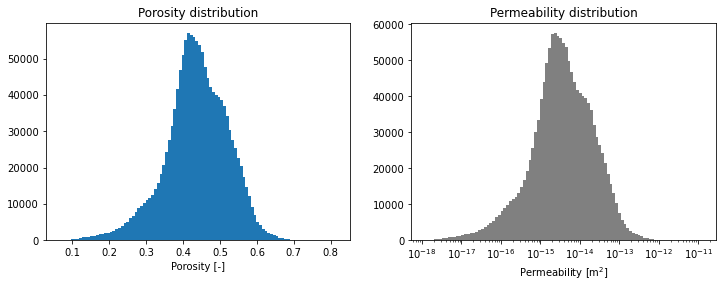

,X,Y,Z,Porosity,Sequence
0,250.0,250.0,-30.0,43.225471,m1
1,250.0,750.0,-30.0,37.984227,m1
2,250.0,1250.0,-30.0,35.320263,m1
3,250.0,1750.0,-30.0,37.963489,m1
4,250.0,2250.0,-30.0,38.461496,m1


In [6]:
# Por to perm conversion with linear regression
perm_lin = gen_perm_lin(results_df['Porosity'].values/100)


# Visualization QC
# Checking the distribution 

figure,axs=plt.subplots(1,2,figsize=(12,4))
axs[0].hist(results_df['Porosity'].values/100,bins=100)
axs[0].set_xlabel('Porosity [-]')
axs[0].set_title('Porosity distribution')


axs[1].hist(perm_lin,color='gray',bins = 10 ** np.linspace(np.log10(min(perm_lin)), np.log10(max(perm_lin)), 100));
axs[1].set_xlabel('Permeability [m$^2$]')
axs[1].set_xscale('log')
axs[1].set_title('Permeability distribution')

plt.show()

results_df.head()

## Write data to results folder

In [7]:
# Write Permeability into df
results_df.insert (4, "Permeability", perm_lin)
realization_name = str("Model_realization_por-perm_"+datetime.datetime.now().strftime("%Y%m%d"))
results_df.to_csv("Results/"+realization_name+".csv", index=False)

results_df.head()

,X,Y,Z,Porosity,Permeability,Sequence
0,250.0,250.0,-30.0,43.225471,3.200420e-15,m1
1,250.0,750.0,-30.0,37.984227,1.035904e-15,m1
2,250.0,1250.0,-30.0,35.320263,5.838811e-16,m1
3,250.0,1750.0,-30.0,37.963489,1.031291e-15,m1
4,250.0,2250.0,-30.0,38.461496,1.147965e-15,m1


## 3D view of Permeability distribution 

Note: More integrated plotting methods are provided in notebook (6) Plotting routines.

In [8]:

# set plotter
p = pvqt.BackgroundPlotter()

pc = pv.PolyData(np.c_[results_df["X"].values, results_df["Y"].values, results_df["Z"].values])

# set permeability
pc["Permeability [m^2]"]=perm_lin
#pc["Porosity"]=results_df["Porosity"].values
# calculate voxel sizes
spacing = lambda arr: np.unique(np.diff(np.unique(arr)))
voxelsize = spacing(pc.points[:,0]), spacing(pc.points[:,1]), spacing(pc.points[:,2])

# create voxel model
pc = pc.cast_to_unstructured_grid()
grid = PVGeo.filters.VoxelizePoints(dx=voxelsize[0][0], dy=voxelsize[1][0], dz=voxelsize[2][0], estimate=False).apply(pc)

# for discrete colormap (here with 5 classes)
#cmap = plt.cm.get_cmap("viridis", 5)
#p.add_mesh(grid, opacity=1, show_edges=False, lighting=False, cmap=cmap)

# for continuous colormap

p.add_mesh(grid, opacity=1, show_edges=False, lighting=False,log_scale=True, cmap="viridis")

p.set_scale(zscale=30)
p.camera_position = (-320, -200, 3)
p.show_grid(xlabel="X [m]", ylabel="Y [m]", zlabel="Z [m]")
p.show()